In [28]:
# import
import os
import numpy as np
import random

import keras
import tensorflow as tf


In [29]:
# import my google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
# read fasta files
fasta_file_path='gdrive/My Drive/data_samples/'
rbp_name = 'ELAVL1'
print('list of files', os.listdir(fasta_file_path))

list of files ['CLIPSEQ_ELAVL1.train.positives.fasta', 'ALKBH5_Baltz2012.train.negatives.fasta', 'ALKBH5_Baltz2012.test_negatives.fasta', 'CLIPSEQ_ELAVL1.test.positives.fasta', 'ALKBH5_Baltz2012.train.positives.fasta', 'CLIPSEQ_ELAVL1.train.negatives.fasta', 'ALKBH5_Baltz2012.test.positives.fasta', 'CLIPSEQ_ELAVL1.test.negatives.fasta']


In [31]:
# loading training set
train_fasta = list()
train_label = list()
for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name in x and 'train' in x]:
  print('Processing file...', single_file)
  with open(fasta_file_path + single_file) as f:
    for line in f.readlines():
      # get fasta sequence
      if '>' in line:
        continue
      else:
        train_fasta.append(line.strip())
      # get positive negative label
      if 'positives' in single_file:
        train_label.append(1)
      else:
        train_label.append(0)



Processing file... CLIPSEQ_ELAVL1.train.positives.fasta
Processing file... CLIPSEQ_ELAVL1.train.negatives.fasta


In [32]:
def convert2onehot(sequence_list):
  map = {
      'A':[1,0,0,0],
      'U':[0,1,0,0],
      'T':[0,1,0,0],
      'G':[0,0,1,0],
      'C':[0,0,0,1]
  }

  onehot = []
  for single_sequence in sequence_list:
    single_onehot = []
    for x in single_sequence:
      single_onehot.append(map[x.upper()])
    onehot.append(single_onehot)

  return np.asarray(onehot, dtype=np.float32)

data_input = convert2onehot(train_fasta)
data_label = keras.utils.to_categorical(train_label, 2)

In [33]:
print("Input shape",data_input.shape)
print("Label shape",data_label.shape)

Input shape (16550, 200, 4)
Label shape (16550, 2)


In [34]:
# split training set into training set and validation set
# random shuffling of training data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data_input, data_label, test_size=0.20, random_state=42)
###################
print("size of X_train",X_train.shape)
print("size of X_test",X_val.shape)
print("size of y_train",y_train.shape)
print("size of y_test",y_val.shape)
# ###################
# print('Dataset preparation done... train_input, train_label, validation_input, validation_label')
# print('Size of each set...', train_input.shape, train_label.shape, validation_input.shape, validation_label.shape)

size of X_train (13240, 200, 4)
size of X_test (3310, 200, 4)
size of y_train (13240, 2)
size of y_test (3310, 2)


In [35]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Flatten, Dense, Dropout
input = Input(shape=(200, 4))
input2 = Reshape((200,4,1))(input)
hidden = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(input2)
hidden = MaxPooling2D((2,2))(hidden)
hidden = Dropout(rate=0.3)(hidden)
hidden = Flatten()(hidden)
output = Dense(2, activation='softmax')(hidden)

model = tf.keras.Model(inputs=input, outputs=output)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200, 4)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 200, 4, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 198, 2, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 99, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 99, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3168)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           6,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,658 (26.01 KB)

 Trainable params: 6,658 (26.01 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from tensorflow.keras.metrics import AUC
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

In [37]:
hist = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val))

Epoch 1/200
414/414 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7447 - auc: 0.8212 - loss: 0.5017 - val_accuracy: 0.9082 - val_auc: 0.9641 - val_loss: 0.2488
Epoch 2/200
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9001 - auc: 0.9591 - loss: 0.2615 - val_accuracy: 0.9196 - val_auc: 0.9712 - val_loss: 0.2187
Epoch 3/200
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9092 - auc: 0.9656 - loss: 0.2392 - val_accuracy: 0.9230 - val_auc: 0.9717 - val_loss: 0.2151
Epoch 4/200
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9158 - auc: 0.9698 - loss: 0.2225 - val_accuracy: 0.9218 - val_auc: 0.9731 - val_loss: 0.2099
Epoch 5/200
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9181 - auc: 0.9714 - loss: 0.2154 - val_accuracy: 0.9239 - val_auc: 0.9740 - val_loss: 0.2045
Epoch 6/200
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9213 - auc: 0.9716 - loss: 0.2138 - val_accuracy: 0.9224 - val_auc: 0.9746 - val_loss: 0.2024
Epoch 7/200
414/414 ━━━━━━━━━━━━

In [38]:
model.summary()
model.save('CLIPSEQ_ELAVL1_new_base_model.h5')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200, 4)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 200, 4, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 198, 2, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 99, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 99, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3168)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           6,338 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,976 (78.04 KB)

 Trainable params: 6,658 (26.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,318 (52.03 KB)

In [39]:
!cp -r /content/CLIPSEQ_ELAVL1_new_base_model.h5 /content/gdrive/MyDrive/CLIPSEQ_ELAVL1/

cp: cannot create regular file '/content/gdrive/MyDrive/CLIPSEQ_ELAVL1/': Not a directory


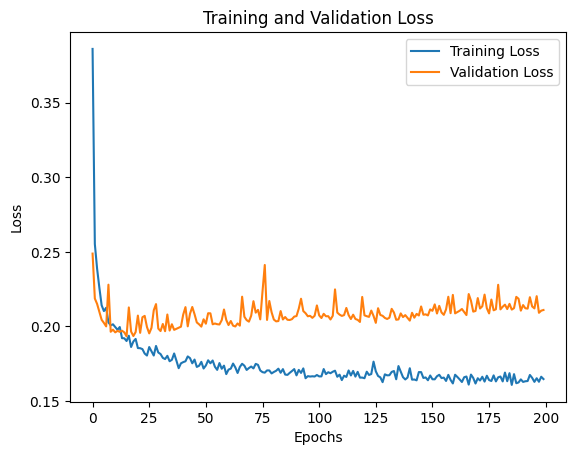

In [40]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Loading Test Data

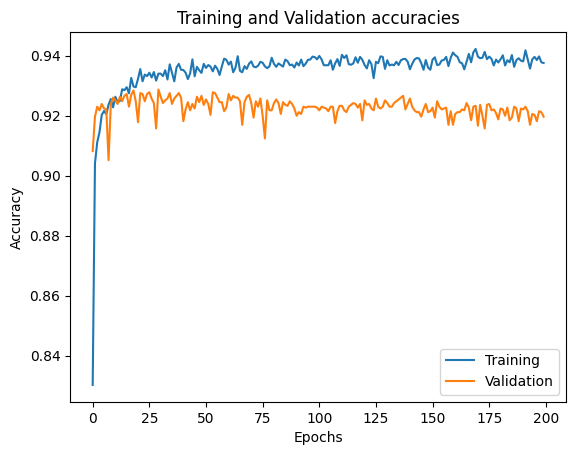

In [41]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'], label='Training')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
# loading test set
rbp_name = 'ELAVL1'
test_fasta = list()
test_label = list()
for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name in x and 'test' in x]:
  print('Processing file...', single_file)
  with open(fasta_file_path + single_file) as f:
    for line in f.readlines():
      # get fasta sequence
      if '>' in line:
        continue
      else:
        test_fasta.append(line.strip())
      # get positive negative label
      if 'positives' in single_file:
        test_label.append(1)
      else:
        test_label.append(0)


Processing file... CLIPSEQ_ELAVL1.test.positives.fasta
Processing file... CLIPSEQ_ELAVL1.test.negatives.fasta


This is when you only load model, just for inference.

In [43]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, precision_score

# Load the saved Keras model
model_Eval = tf.keras.models.load_model('/content/CLIPSEQ_ELAVL1_new_base_model.h5')
test_input_Eval = convert2onehot(test_fasta)
test_label_Eval = keras.utils.to_categorical(test_label, 2)
print('TEST set prepared...', test_input_Eval.shape, test_label_Eval.shape)

TEST set prepared... (975, 200, 4) (975, 2)


In [18]:
# Evaluate the model
results = model_Eval.evaluate(test_input_Eval, test_label_Eval)
loss = results[0]  # First value is loss
accuracy = results[1]  # Second value is accuracy (if available)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9001 - auc: 0.9520 - loss: 0.3114
Loss: 0.2188, Accuracy: 0.9159


In [19]:
# Evaluate the model
results = model_Eval.evaluate(X_train, y_train)
loss = results[0]  # First value is loss
accuracy = results[1]  # Second value is accuracy (if available)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9602 - auc: 0.9905 - loss: 0.1194
Loss: 0.1230, Accuracy: 0.9595


In [20]:
# Evaluate the model
results = model_Eval.evaluate(X_val, y_val)
loss = results[0]  # First value is loss
accuracy = results[1]  # Second value is accuracy (if available)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9201 - auc: 0.9749 - loss: 0.2107
Loss: 0.2127, Accuracy: 0.9199


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


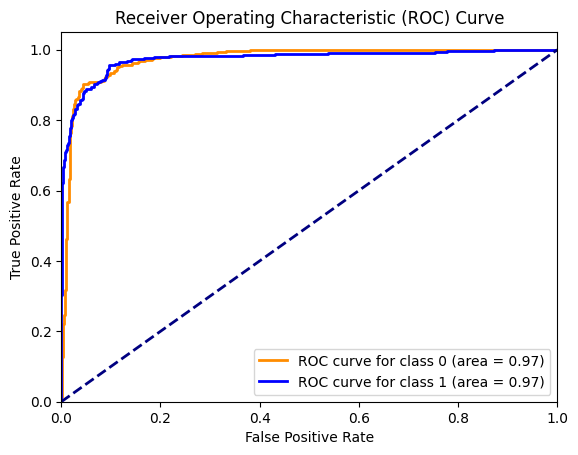

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Predict the probabilities for the test set
y_pred_prob = model_Eval.predict(test_input_Eval)

# Get the true labels (if they're not already one-hot encoded)
y_true = test_label_Eval

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
average_precision = {}

# Calculate ROC for each class
for i in range(2):  # Assuming 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Precision-Recall
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred_prob[:, i])


plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve for class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue', lw=lw, label='ROC curve for class 1 (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Compute the average precision for each class
average_precision_per_class = {class_id: np.mean(precisions) for class_id, precisions in precision.items()}
average_recall_per_class = {class_id: np.mean(recall) for class_id, recall in recall.items()}

# Compute the overall average precision across all classes
overall_average_precision = np.mean(list(average_precision_per_class.values()))
overall_average_recall = np.mean(list(average_recall_per_class.values()))


# Print the results
print("Average precision per class:", average_precision_per_class)
print("Overall average precision across all classes:", overall_average_precision)
print("Average recall per class:", average_recall_per_class)
print("Overall average recall across all classes:", overall_average_recall)

Average precision per class: {0: 0.8326806868949433, 1: 0.8271369248051408}
Overall average precision across all classes: 0.8299088058500421
Average recall per class: {0: 0.7335563356958337, 1: 0.7404385844826995}
Overall average recall across all classes: 0.7369974600892666


AUC value on test Set

414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


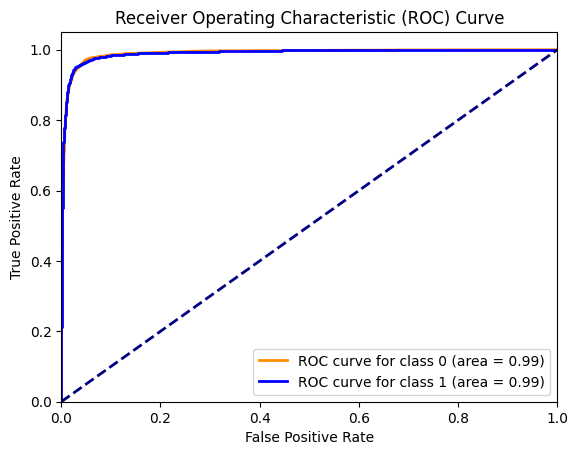

In [24]:
##### Trainign ############3
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Predict the probabilities for the test set
y_pred_prob = model_Eval.predict(X_train)

# Get the true labels (if they're not already one-hot encoded)
y_true = y_train

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
average_precision = {}

# Calculate ROC for each class
for i in range(2):  # Assuming 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Precision-Recall
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred_prob[:, i])


plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve for class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue', lw=lw, label='ROC curve for class 1 (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [25]:
# Compute the average precision for each class
average_precision_per_class = {class_id: np.mean(precisions) for class_id, precisions in precision.items()}
average_recall_per_class = {class_id: np.mean(recall) for class_id, recall in recall.items()}

# Compute the overall average precision across all classes
overall_average_precision = np.mean(list(average_precision_per_class.values()))
overall_average_recall = np.mean(list(average_recall_per_class.values()))


# Print the results
print("Average precision per class:", average_precision_per_class)
print("Overall average precision across all classes:", overall_average_precision)
print("Average recall per class:", average_recall_per_class)
print("Overall average recall across all classes:", overall_average_recall)

Average precision per class: {0: 0.8395515328569824, 1: 0.8351374302894429}
Overall average precision across all classes: 0.8373444815732126
Average recall per class: {0: 0.7665280219603866, 1: 0.752645764486666}
Overall average recall across all classes: 0.7595868932235263


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


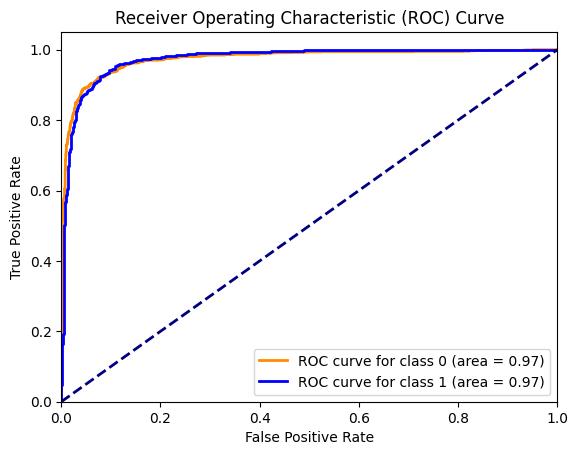

In [26]:
##### Validation ############3
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Predict the probabilities for the test set
y_pred_prob = model_Eval.predict(X_val)

# Get the true labels (if they're not already one-hot encoded)
y_true = y_val

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
average_precision = {}

# Calculate ROC for each class
for i in range(2):  # Assuming 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Precision-Recall
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred_prob[:, i])


plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve for class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue', lw=lw, label='ROC curve for class 1 (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
# Compute the average precision for each class
average_precision_per_class = {class_id: np.mean(precisions) for class_id, precisions in precision.items()}
average_recall_per_class = {class_id: np.mean(recall) for class_id, recall in recall.items()}

# Compute the overall average precision across all classes
overall_average_precision = np.mean(list(average_precision_per_class.values()))
overall_average_recall = np.mean(list(average_recall_per_class.values()))


# Print the results
print("Average precision per class:", average_precision_per_class)
print("Overall average precision across all classes:", overall_average_precision)
print("Average recall per class:", average_recall_per_class)
print("Overall average recall across all classes:", overall_average_recall)

Average precision per class: {0: 0.828943494951274, 1: 0.8312829283929571}
Overall average precision across all classes: 0.8301132116721155
Average recall per class: {0: 0.7463421409133582, 1: 0.7369108541738351}
Overall average recall across all classes: 0.7416264975435967


Now the Second Dataset **ALKBH5_Baltz2012**

Now the Second Dataset **ALKBH5_Baltz2012**

In [44]:
# loading training set
rbp_name = 'Baltz2012'
train_fasta1 = list()
train_label1 = list()
for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name in x and 'train' in x]:
  print('Processing file...', single_file)
  with open(fasta_file_path + single_file) as f:
    for line in f.readlines():
      # get fasta sequence
      if '>' in line:
        continue
      else:
        train_fasta1.append(line.strip())
      # get positive negative label
      if 'positives' in single_file:
        train_label1.append(1)
      else:
        train_label1.append(0)

Processing file... ALKBH5_Baltz2012.train.negatives.fasta
Processing file... ALKBH5_Baltz2012.train.positives.fasta


In [45]:
def convert2onehot(sequence_list):
  map = {
      'A':[1,0,0,0],
      'U':[0,1,0,0],
      'T':[0,1,0,0],
      'G':[0,0,1,0],
      'C':[0,0,0,1]
  }

  onehot = []
  for single_sequence in sequence_list:
    single_onehot = []
    for x in single_sequence:
      single_onehot.append(map[x.upper()])
    onehot.append(single_onehot)

  return np.asarray(onehot, dtype=np.float32)

data_input = convert2onehot(train_fasta1)
data_label = keras.utils.to_categorical(train_label1, 2)

In [46]:
print("Input shape",data_input.shape)
print("Label shape",data_label.shape)

Input shape (2361, 200, 4)
Label shape (2361, 2)


In [47]:
# split training set into training set and validation set
# random shuffling of training data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data_input, data_label, test_size=0.20, random_state=42)
###################
print("size of X_train",X_train.shape)
print("size of X_test",X_val.shape)
print("size of y_train",y_train.shape)
print("size of y_test",y_val.shape)
# ###################
# print('Dataset preparation done... train_input, train_label, validation_input, validation_label')
# print('Size of each set...', train_input.shape, train_label.shape, validation_input.shape, validation_label.shape)

size of X_train (1888, 200, 4)
size of X_test (473, 200, 4)
size of y_train (1888, 2)
size of y_test (473, 2)


In [48]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

input = Input(shape=(200, 4))
input2 = Reshape((200,4,1))(input)

hidden1 = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu')(input2)
hidden1 = MaxPooling2D((2,2))(hidden1)
hidden1 = Dropout(rate=0.3)(hidden1)

hidden2 = Conv2D(filters=16, kernel_size=(2,2), strides=(1,1), padding='same', activation='relu')(hidden1)
# hidden2 = MaxPooling2D((2,2))(hidden2)
hidden2 = Dropout(rate=0.3)(hidden2)
hidden2 = Flatten()(hidden2)
output = Dense(2, activation='softmax')(hidden2)

model = tf.keras.Model(inputs=input, outputs=output)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 200, 4)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 200, 4, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 198, 2, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 99, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 99, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 99, 1, 16)           │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 99, 1, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1584)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           3,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,554 (21.70 KB)

 Trainable params: 5,554 (21.70 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
from tensorflow.keras.metrics import AUC
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', AUC(name='auc')])

In [51]:
hist = model.fit(X_train, y_train, epochs=300, validation_data=(X_val, y_val))

Epoch 1/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.5199 - auc: 0.5289 - loss: 0.6968 - val_accuracy: 0.4545 - val_auc: 0.4758 - val_loss: 0.6944
Epoch 2/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5190 - auc: 0.5463 - loss: 0.6900 - val_accuracy: 0.5201 - val_auc: 0.5429 - val_loss: 0.6908
Epoch 3/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5490 - auc: 0.5704 - loss: 0.6860 - val_accuracy: 0.5285 - val_auc: 0.5299 - val_loss: 0.6918
Epoch 4/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5884 - auc: 0.6236 - loss: 0.6755 - val_accuracy: 0.5391 - val_auc: 0.5452 - val_loss: 0.6904
Epoch 5/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5694 - auc: 0.6059 - loss: 0.6763 - val_accuracy: 0.5560 - val_auc: 0.5687 - val_loss: 0.6878
Epoch 6/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5978 - auc: 0.6396 - loss: 0.6628 - val_accuracy: 0.5603 - val_auc: 0.5748 - val_loss: 0.6874
Epoch 7/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms

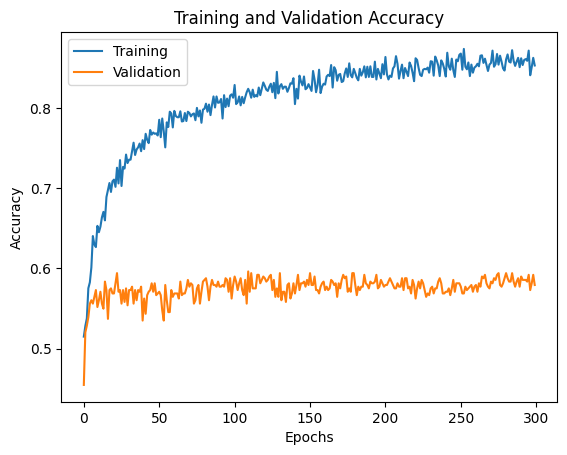

In [52]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'], label='Training')
plt.plot(hist.history['val_accuracy'], label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

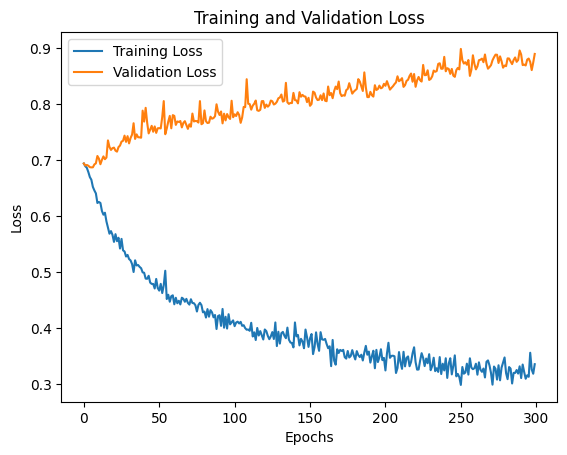

In [54]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

AUC value on test Set

In [55]:
model.summary()
model.save('ALKBH5_Baltz2012_model.h5')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 200, 4)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 200, 4, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 198, 2, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 99, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 99, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 99, 1, 16)           │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 99, 1, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1584)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │           3,170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,664 (65.10 KB)

 Trainable params: 5,554 (21.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,110 (43.40 KB)

In [56]:
# loading test_baltz set
rbp_name = 'Baltz2012'
test_fasta2 = list()
test_label2 = list()
for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name in x and 'test' in x]:
  print('Processing file...', single_file)
  with open(fasta_file_path + single_file) as f:
    for line in f.readlines():
      # get fasta sequence
      if '>' in line:
        continue
      else:
        test_fasta2.append(line.strip())
      # get positive negative label
      if 'positives' in single_file:
        test_label2.append(1)
      else:
        test_label2.append(0)

Processing file... ALKBH5_Baltz2012.test_negatives.fasta
Processing file... ALKBH5_Baltz2012.test.positives.fasta


Loading the trained model

In [57]:
##Loading the model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, precision_score

# Load the saved Keras model
model = tf.keras.models.load_model('/content/ALKBH5_Baltz2012_model.h5')
test_input1 = convert2onehot(test_fasta2)
test_label1 = keras.utils.to_categorical(test_label2, 2)
print('TEST set prepared...', test_input1.shape, test_label1.shape)

TEST set prepared... (262, 200, 4) (262, 2)


In [58]:
# Evaluate the model on traing set
results = model.evaluate(X_train, y_train)
loss = results[0]  # First value is loss
accuracy = results[1]  # Second value is accuracy (if available)
print(f"Loss: {loss:.4f}, Train Accuracy: {accuracy:.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9846 - auc: 0.9990 - loss: 0.1525
Loss: 0.1519, Train Accuracy: 0.9878


In [59]:
# Evaluate the model on test set
results = model.evaluate(test_input1, test_label1)
loss = results[0]  # First value is loss
accuracy = results[1]  # Second value is accuracy (if available)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.4324 - auc: 0.4540 - loss: 1.1492
Loss: 0.9986, Accuracy: 0.5153


In [ ]:
# Evaluate the model on traing set
results = model.evaluate(X_val, y_val)
loss = results[0]  # First value is loss
accuracy = results[1]  # Second value is accuracy (if available)
print(f"Loss: {loss:.4f}, val Accuracy: {accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8959 - auc: 0.9290 - loss: 0.3301 
Loss: 0.3038, val Accuracy: 0.9091


In [ ]:

# calculate AUC score for test sets
test_input1 = convert2onehot(test_fasta2)
test_label1 = keras.utils.to_categorical(test_label2, 2)
print('TEST set prepared...', test_input1.shape, test_label1.shape)
###################
from sklearn.metrics import roc_auc_score
y_pred_prob = model.predict(test_input1)
y_pred_prob_class1 = y_pred_prob
auc = roc_auc_score(test_label1, y_pred_prob_class1)
print(f"AUC Score on Test Set: {auc}")

###################

TEST set prepared... (975, 200, 4) (975, 2)
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step
AUC Score on Test Set: 0.6218751820989453


In [ ]:
# AUC Score on Test
###################
from sklearn.metrics import roc_auc_score
y_pred_prob = model.predict(test_input1)
y_pred_prob_class1 = y_pred_prob
auc = roc_auc_score(test_label1, y_pred_prob_class1)
print(f"AUC Score on Test Set: {auc}")

###################

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC Score on Test Set: 0.5823669949303654


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


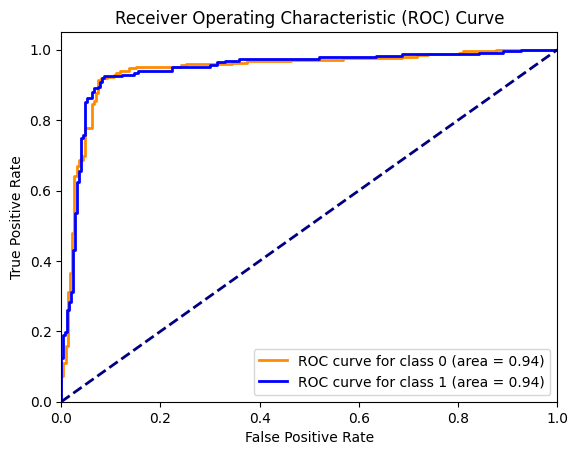

In [ ]:
#### On validation Data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Predict the probabilities for the test set
y_pred_prob = model.predict(X_val)

# Get the true labels (if they're not already one-hot encoded)
y_true = y_val #test_label1

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
average_precision = {}

# Calculate ROC for each class
for i in range(2):  # Assuming 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Precision-Recall
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred_prob[:, i])


plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve for class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue', lw=lw, label='ROC curve for class 1 (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute the average precision for each class ### Validation
average_precision_per_class = {class_id: np.mean(precisions) for class_id, precisions in precision.items()}
average_recall_per_class = {class_id: np.mean(recall) for class_id, recall in recall.items()}

# Compute the overall average precision across all classes
overall_average_precision = np.mean(list(average_precision_per_class.values()))
overall_average_recall = np.mean(list(average_recall_per_class.values()))


# Print the results
print("Average precision per class:", average_precision_per_class)
print("Overall average precision across all classes:", overall_average_precision)
print("Average recall per class:", average_recall_per_class)
print("Overall average recall across all classes:", overall_average_recall)

Average precision per class: {0: 0.8241257722806028, 1: 0.7952514722504692}
Overall average precision across all classes: 0.809688622265536
Average recall per class: {0: 0.7118966759287847, 1: 0.7296325210505772}
Overall average recall across all classes: 0.7207645984896809


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step


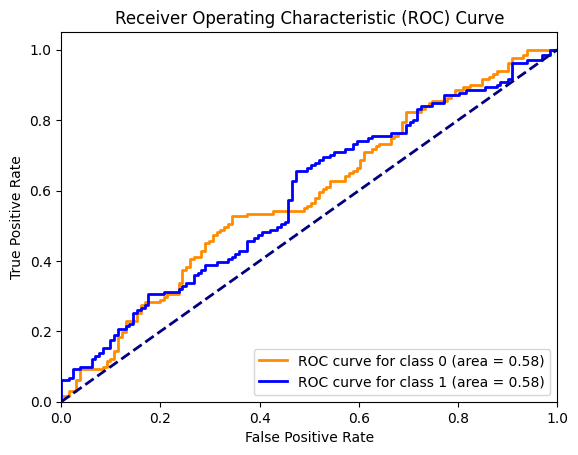

In [ ]:
######### AUC on Test ####
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Predict the probabilities for the test set
y_pred_prob = model.predict(test_input1)

# Get the true labels (if they're not already one-hot encoded)
y_true = test_label1

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
average_precision = {}

# Calculate ROC for each class
for i in range(2):  # Assuming 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Precision-Recall
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred_prob[:, i])


plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve for class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue', lw=lw, label='ROC curve for class 1 (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute the average precision for each class #### Test Data
average_precision_per_class = {class_id: np.mean(precisions) for class_id, precisions in precision.items()}
average_recall_per_class = {class_id: np.mean(recall) for class_id, recall in recall.items()}

# Compute the overall average precision across all classes
overall_average_precision = np.mean(list(average_precision_per_class.values()))
overall_average_recall = np.mean(list(average_recall_per_class.values()))


# Print the results
print("Average precision per class:", average_precision_per_class)
print("Overall average precision across all classes:", overall_average_precision)
print("Average recall per class:", average_recall_per_class)
print("Overall average recall across all classes:", overall_average_recall)

Average precision per class: {0: 0.564443735403178, 1: 0.5814363529336367}
Overall average precision across all classes: 0.5729400441684074
Average recall per class: {0: 0.541026906220068, 1: 0.541026906220068}
Overall average recall across all classes: 0.541026906220068


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


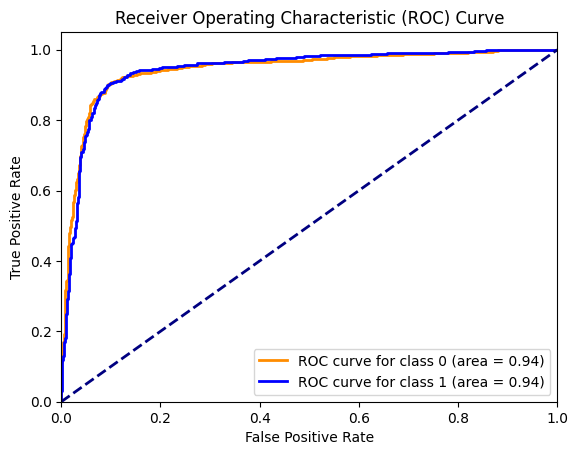

In [ ]:
######### AUC on Train ####
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Predict the probabilities for the test set
y_pred_prob = model.predict(X_train)

# Get the true labels (if they're not already one-hot encoded)
y_true = y_train #test_label1

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
average_precision = {}

# Calculate ROC for each class
for i in range(2):  # Assuming 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Precision-Recall
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred_prob[:, i])


plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve for class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue', lw=lw, label='ROC curve for class 1 (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute the average precision for each class #### Test Data
average_precision_per_class = {class_id: np.mean(precisions) for class_id, precisions in precision.items()}
average_recall_per_class = {class_id: np.mean(recall) for class_id, recall in recall.items()}

# Compute the overall average precision across all classes
overall_average_precision = np.mean(list(average_precision_per_class.values()))
overall_average_recall = np.mean(list(average_recall_per_class.values()))


# Print the results
print("Average precision per class:", average_precision_per_class)
print("Overall average precision across all classes:", overall_average_precision)
print("Average recall per class:", average_recall_per_class)
print("Overall average recall across all classes:", overall_average_recall)

Average precision per class: {0: 0.8120234085839002, 1: 0.8136462443368913}
Overall average precision across all classes: 0.8128348264603957
Average recall per class: {0: 0.7233414554924168, 1: 0.7205497812761696}
Overall average recall across all classes: 0.7219456183842932


In [63]:
# import
import os
import numpy as np
import random

import keras
import tensorflow as tf
# import my google drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [65]:
# read fasta files
fasta_file_path='gdrive/My Drive/data_samples/'
rbp_name = 'ELAVL1'
print('list of files', os.listdir(fasta_file_path))

list of files ['CLIPSEQ_ELAVL1.train.positives.fasta', 'ALKBH5_Baltz2012.train.negatives.fasta', 'ALKBH5_Baltz2012.test_negatives.fasta', 'CLIPSEQ_ELAVL1.test.positives.fasta', 'ALKBH5_Baltz2012.train.positives.fasta', 'CLIPSEQ_ELAVL1.train.negatives.fasta', 'ALKBH5_Baltz2012.test.positives.fasta', 'CLIPSEQ_ELAVL1.test.negatives.fasta']


In [66]:
# loading training set
rbp_name = 'Baltz2012'
train_fasta1 = list()
train_label1 = list()
for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name in x and 'train' in x]:
  print('Processing file...', single_file)
  with open(fasta_file_path + single_file) as f:
    for line in f.readlines():
      # get fasta sequence
      if '>' in line:
        continue
      else:
        train_fasta1.append(line.strip())
      # get positive negative label
      if 'positives' in single_file:
        train_label1.append(1)
      else:
        train_label1.append(0)



Processing file... ALKBH5_Baltz2012.train.negatives.fasta
Processing file... ALKBH5_Baltz2012.train.positives.fasta


In [67]:
def convert2onehot(sequence_list):
  map = {
      'A':[1,0,0,0],
      'U':[0,1,0,0],
      'T':[0,1,0,0],
      'G':[0,0,1,0],
      'C':[0,0,0,1]
  }

  onehot = []
  for single_sequence in sequence_list:
    single_onehot = []
    for x in single_sequence:
      single_onehot.append(map[x.upper()])
    onehot.append(single_onehot)

  return np.asarray(onehot, dtype=np.float32)

data_input = convert2onehot(train_fasta1)
data_label = keras.utils.to_categorical(train_label1, 2)

In [ ]:
print("Input shape",data_input.shape)
print("Label shape",data_label.shape)

Input shape (2361, 200, 4)
Label shape (2361, 2)


In [68]:
# split training set into training set and validation set
# random shuffling of training data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data_input, data_label, test_size=0.20, random_state=42)
###################
print("size of X_train",X_train.shape)
print("size of X_test",X_val.shape)
print("size of y_train",y_train.shape)
print("size of y_test",y_val.shape)
# ###################
# print('Dataset preparation done... train_input, train_label, validation_input, validation_label')
# print('Size of each set...', train_input.shape, train_label.shape, validation_input.shape, validation_label.shape)

size of X_train (1888, 200, 4)
size of X_test (473, 200, 4)
size of y_train (1888, 2)
size of y_test (473, 2)


AUC value on test Set

**Fine Tunning**
Task 3

In [70]:
from tensorflow.keras import models, layers, optimizers, losses, metrics

base_model = models.load_model('/content/CLIPSEQ_ELAVL1_new_base_model.h5')

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  7


In [71]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Reshape # Import the Reshape layer
from tensorflow.keras.layers import Dropout

input_tensor = base_model.layers[1].output  # choose how many layers you want to keep
input = Input(shape=(200, 4))
input_tensor = Reshape((200, 4, 1))(input_tensor)  # Reshape for convolution

# Adding convolutional layers and flattening the output
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu',kernel_regularizer=l2(0.001))(input_tensor)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.3)(x)
x = layers.Flatten()(x)  # Flatten to match the target shape

# Dense layer with 2 outputs (for 2 classes)
h1 = layers.Dense(2, name='dense_new_1')(x)
out = layers.Activation('softmax')(h1)

# Creating the model
new_model = models.Model(base_model.input, outputs=out)

# Freezing the base_model layers (you can choose to fine-tune if necessary)
for layer in base_model.layers:
    layer.trainable = True

# Display number of layers in the new model
print("Number of layers in the new model: ", len(new_model.layers))

# Compile the model
new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', AUC(name='auc')])

# Now you can use new_model for training or fine-tuning



Number of layers in the new model:  9


In [72]:
hist_tuned = new_model.fit(X_train, y_train, epochs=300, validation_data=(X_val, y_val))

Epoch 1/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.5068 - auc: 0.5080 - loss: 0.7119 - val_accuracy: 0.4947 - val_auc: 0.5228 - val_loss: 0.7049
Epoch 2/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5810 - auc: 0.6110 - loss: 0.6741 - val_accuracy: 0.5793 - val_auc: 0.5818 - val_loss: 0.6933
Epoch 3/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5817 - auc: 0.6305 - loss: 0.6664 - val_accuracy: 0.5560 - val_auc: 0.5770 - val_loss: 0.6844
Epoch 4/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6262 - auc: 0.6778 - loss: 0.6484 - val_accuracy: 0.5729 - val_auc: 0.5951 - val_loss: 0.6798
Epoch 5/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6522 - auc: 0.7083 - loss: 0.6357 - val_accuracy: 0.5856 - val_auc: 0.5926 - val_loss: 0.6809
Epoch 6/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7010 - auc: 0.7539 - loss: 0.6078 - val_accuracy: 0.5603 - val_auc: 0.5961 - val_loss: 0.6822
Epoch 7/300
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms

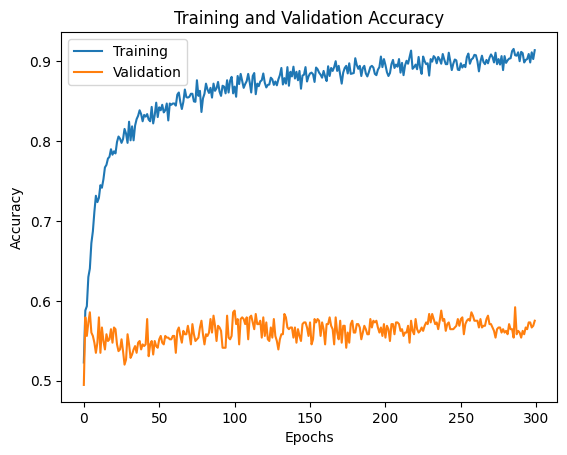

In [73]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(hist_tuned.history['accuracy'], label='Training')
plt.plot(hist_tuned.history['val_accuracy'], label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
new_model.summary()
new_model.save('Fine_tuned_ELAVL1_new_base_model.h5')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 4)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 200, 4, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 200, 4, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 198, 2, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 99, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 99, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3168)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_new_1 (Dense)                  │ (None, 2)                   │           6,338 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,976 (78.04 KB)

 Trainable params: 6,658 (26.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,318 (52.03 KB)

In [ ]:
!cp -r /content/Fine_tuned_ELAVL1_new_base_model.h5 /content/gdrive/MyDrive/

In [ ]:
# loading test_baltz set
rbp_name = 'Baltz2012'
test_fasta2 = list()
test_label2 = list()
for single_file in [x for x in os.listdir(fasta_file_path) if rbp_name in x and 'test' in x]:
  print('Processing file...', single_file)
  with open(fasta_file_path + single_file) as f:
    for line in f.readlines():
      # get fasta sequence
      if '>' in line:
        continue
      else:
        test_fasta2.append(line.strip())
      # get positive negative label
      if 'positives' in single_file:
        test_label2.append(1)
      else:
        test_label2.append(0)

Processing file... ALKBH5_Baltz2012.test_negatives.fasta
Processing file... ALKBH5_Baltz2012.test.positives.fasta


In [ ]:
##Loading the model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, precision_score

# Load the saved Keras model
model = tf.keras.models.load_model('/content/gdrive/MyDrive/Fine_tuned_ELAVL1_new_base_model.h5')
test_input1 = convert2onehot(test_fasta2)
test_label1 = keras.utils.to_categorical(test_label2, 2)
print('TEST set prepared...', test_input1.shape, test_label1.shape)

TEST set prepared... (262, 200, 4) (262, 2)


In [ ]:
# Evaluate the model ### test set
results = model.evaluate(test_input1, test_label1)
loss = results[0]  # First value is loss
accuracy = results[1]  # Second value is accuracy (if available)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.5382 - auc: 0.5599 - loss: 1.1883
Loss: 1.0674, Accuracy: 0.5725


In [ ]:
# Evaluate the model ### Train set
results = new_model.evaluate(X_train, y_train)
loss = results[0]  # First value is loss
accuracy = results[1]  # Second value is accuracy (if available)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - auc: 0.9999 - loss: 0.1214
Loss: 0.1257, Accuracy: 0.9931


In [ ]:
# Evaluate the model ### Val set
results = model.evaluate(X_val, y_val)
loss = results[0]  # First value is loss
accuracy = results[1]  # Second value is accuracy (if available)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5476 - auc: 0.5737 - loss: 1.1637
Loss: 1.0937, Accuracy: 0.5814


In [ ]:

################### Test Set
from sklearn.metrics import roc_auc_score
y_pred_prob = new_model.predict(test_input1)
y_pred_prob_class1 = y_pred_prob
auc = roc_auc_score(test_label1, y_pred_prob_class1)
print(f"AUC Score on Test Set: {auc}")

###################

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
AUC Score on Test Set: 0.6078317114387274


In [ ]:

################### val Set
from sklearn.metrics import roc_auc_score
y_pred_prob = model.predict(X_val)
y_pred_prob_class1 = y_pred_prob
auc = roc_auc_score(y_val, y_pred_prob_class1)
print(f"AUC Score on Test Set: {auc}")

###################

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
AUC Score on Test Set: 0.6129644212184122


In [ ]:

################### trianing Set
from sklearn.metrics import roc_auc_score
y_pred_prob = model.predict(X_train)
y_pred_prob_class1 = y_pred_prob
auc = roc_auc_score(y_train, y_pred_prob_class1)
print(f"AUC Score on Test Set: {auc}")

###################

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC Score on Test Set: 0.9998170668749635


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


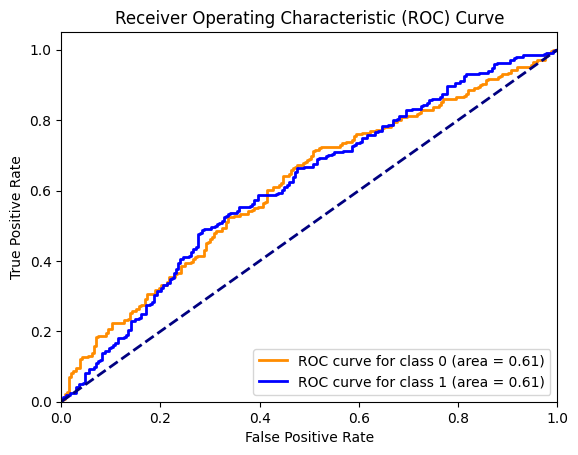

In [ ]:
#### On validation Data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Predict the probabilities for the test set
y_pred_prob = model.predict(X_val)

# Get the true labels (if they're not already one-hot encoded)
y_true = y_val #test_label1

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
average_precision = {}

# Calculate ROC for each class
for i in range(2):  # Assuming 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Precision-Recall
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred_prob[:, i])


plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve for class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue', lw=lw, label='ROC curve for class 1 (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute the average precision for each class ### Validation
average_precision_per_class = {class_id: np.mean(precisions) for class_id, precisions in precision.items()}
average_recall_per_class = {class_id: np.mean(recall) for class_id, recall in recall.items()}

# Compute the overall average precision across all classes
overall_average_precision = np.mean(list(average_precision_per_class.values()))
overall_average_recall = np.mean(list(average_recall_per_class.values()))


# Print the results
print("Average precision per class:", average_precision_per_class)
print("Overall average precision across all classes:", overall_average_precision)
print("Average recall per class:", average_recall_per_class)
print("Overall average recall across all classes:", overall_average_recall)

Average precision per class: {0: 0.5787285458095233, 1: 0.5917576779790646}
Overall average precision across all classes: 0.585243111894294
Average recall per class: {0: 0.5573917298300359, 1: 0.5554708349218452}
Overall average recall across all classes: 0.5564312823759405


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


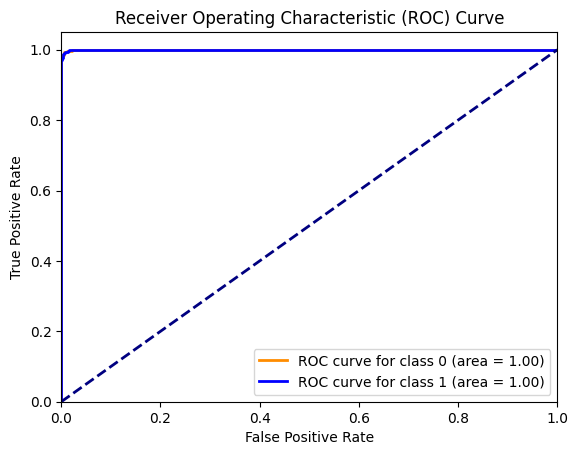

In [ ]:
#### On train Data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Predict the probabilities for the test set
y_pred_prob = model.predict(X_train)

# Get the true labels (if they're not already one-hot encoded)
y_true = y_train #test_label1

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
average_precision = {}

# Calculate ROC for each class
for i in range(2):  # Assuming 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Precision-Recall
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred_prob[:, i])


plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve for class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue', lw=lw, label='ROC curve for class 1 (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute the average precision for each class #### Test Data
average_precision_per_class = {class_id: np.mean(precisions) for class_id, precisions in precision.items()}
average_recall_per_class = {class_id: np.mean(recall) for class_id, recall in recall.items()}

# Compute the overall average precision across all classes
overall_average_precision = np.mean(list(average_precision_per_class.values()))
overall_average_recall = np.mean(list(average_recall_per_class.values()))


# Print the results
print("Average precision per class:", average_precision_per_class)
print("Overall average precision across all classes:", overall_average_precision)
print("Average recall per class:", average_recall_per_class)
print("Overall average recall across all classes:", overall_average_recall)

Average precision per class: {0: 0.8501151790327839, 1: 0.8426476848837571}
Overall average precision across all classes: 0.8463814319582705
Average recall per class: {0: 0.7469963667697118, 1: 0.7524486897978441}
Overall average recall across all classes: 0.749722528283778


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


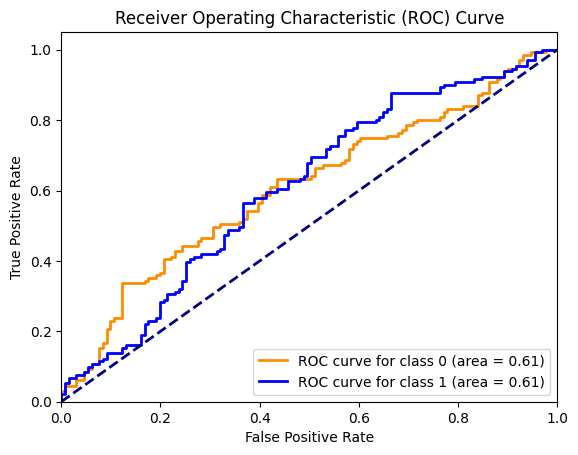

In [ ]:
#### On train Data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# Predict the probabilities for the test set
y_pred_prob = model.predict(test_input1)

# Get the true labels (if they're not already one-hot encoded)
y_true = test_label1 #test_label1

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
precision = {}
recall = {}
average_precision = {}

# Calculate ROC for each class
for i in range(2):  # Assuming 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    # Precision-Recall
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred_prob[:, i])
    average_precision[i] = average_precision_score(y_true[:, i], y_pred_prob[:, i])


plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='ROC curve for class 0 (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='blue', lw=lw, label='ROC curve for class 1 (area = %0.2f)' % roc_auc[1])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute the average precision for each class #### Test Data
average_precision_per_class = {class_id: np.mean(precisions) for class_id, precisions in precision.items()}
average_recall_per_class = {class_id: np.mean(recall) for class_id, recall in recall.items()}

# Compute the overall average precision across all classes
overall_average_precision = np.mean(list(average_precision_per_class.values()))
overall_average_recall = np.mean(list(average_recall_per_class.values()))


# Print the results
print("Average precision per class:", average_precision_per_class)
print("Overall average precision across all classes:", overall_average_precision)
print("Average recall per class:", average_recall_per_class)
print("Overall average recall across all classes:", overall_average_recall)

Average precision per class: {0: 0.5958204793774057, 1: 0.5791271218094295}
Overall average precision across all classes: 0.5874738005934176
Average recall per class: {0: 0.5537108524656779, 1: 0.5537108524656779}
Overall average recall across all classes: 0.5537108524656779
